## Thinking with xarray
6/6

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

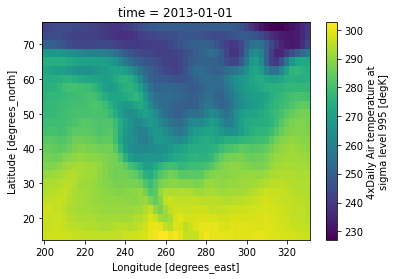

In [3]:
xr.set_options(keep_attrs=True, display_expand_data=False)

da = xr.tutorial.load_dataset('air_temperature').air

monthly = da.resample(time='M').mean()
data = da.isel(time=0)
data.plot()

## Index space v. label space

In [4]:
data

<xarray.DataArray 'air' (lat: 25, lon: 53)>
241.2 242.5 243.5 244.0 244.1 243.9 ... 298.0 297.8 297.6 296.9 296.8 296.6
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [5]:
data[10,:] #10th element along 1st axis

<xarray.DataArray 'air' (lon: 53)>
277.3 277.4 277.8 278.6 279.5 280.1 ... 280.5 282.9 284.7 286.1 286.9 286.6
Coordinates:
    lat      float32 50.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [7]:
data.isel(lat=10) #label space!

<xarray.DataArray 'air' (lon: 53)>
277.3 277.4 277.8 278.6 279.5 280.1 ... 280.5 282.9 284.7 286.1 286.9 286.6
Coordinates:
    lat      float32 50.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [8]:
data.sel(lat=50)

<xarray.DataArray 'air' (lon: 53)>
277.3 277.4 277.8 278.6 279.5 280.1 ... 280.5 282.9 284.7 286.1 286.9 286.6
Coordinates:
    lat      float32 50.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## Index space:
1. rolling: operate on rolling windows of your data eg. running mean
2. coarse: downsample your data

## Label space:
1. groupby: bin data into groups and reduce
2. grouby_bins: GroupBy after discretizing a numeric variable
3. resample: Groupby specialized for time axis. downsample or upsample your data

## Index space

### Index space: windows of fixed width

#### Sliding windows of fixed length: **Rolling**
- returns object of same shape as input
- pads with Nans to make this happen
- supports multiple dimensions

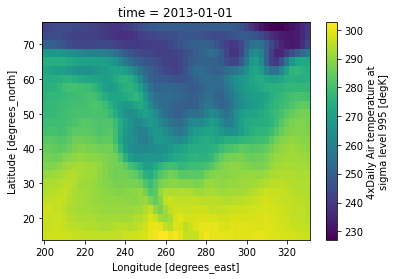

In [9]:
data.plot()

now smoothed 5 point running mean in lat lon:

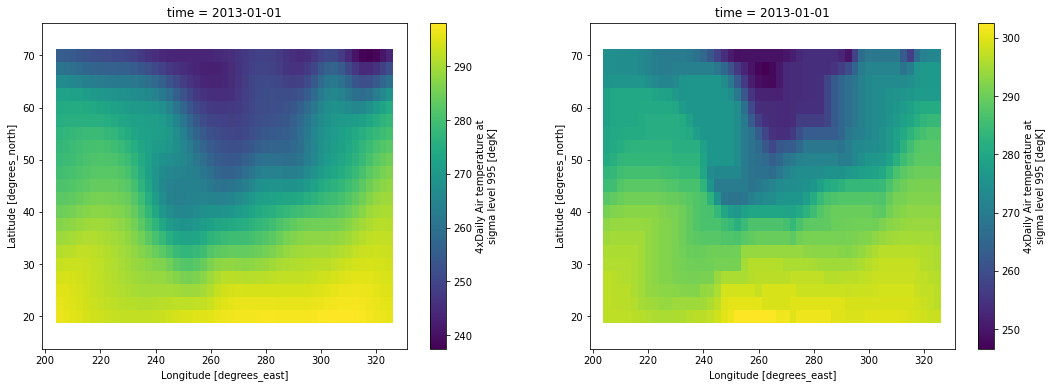

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(18,6))
data.rolling(lat=5, lon=5, center=True).mean().plot(ax=axs[0])
data.rolling(lat=5, lon=5, center=True).max().plot(ax=axs[1])

### Apply an existing numpy-only function with `reduce`

tip: the `reduce` method expects a function that can receive and return plain arrays (eg np arrays). the `map` method expects a function that can receive and return Xarray objects

**Exercise**: calc the rolling mean in 5 point bins along both latittude and longitude using rolling.reduce

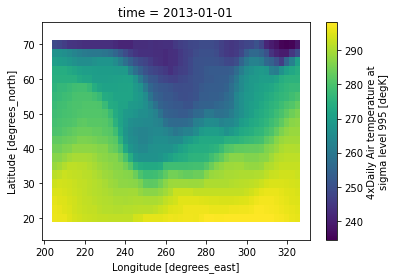

In [28]:
data.rolling(lat=5, lon = 5, center=True).reduce(np.median).plot()

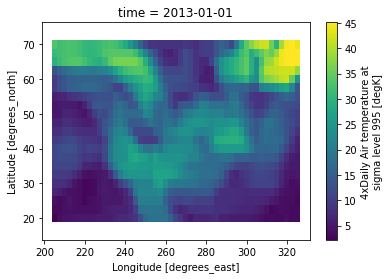

In [30]:
data.rolling(lat=5, lon = 5, center=True).reduce(np.ptp).plot()

## For more complicated analysis (not a reduction), construct a new array with a new dimension

- a reduction takes an array and returns only one or a few values, for things like fourier transform or weighting where you return many values, use construct

In [31]:
#make sample 'time series' data
simple = xr.DataArray(np.arange(10), dims='time', coords={'time': np.arange(10)})
simple

<xarray.DataArray (time: 10)>
0 1 2 3 4 5 6 7 8 9
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9

In [32]:
#make a new dimension called window
simple.rolling(time=5, center=True).construct('window')

<xarray.DataArray (time: 10, window: 5)>
nan nan 0.0 1.0 2.0 nan 0.0 1.0 2.0 3.0 ... 7.0 8.0 9.0 nan 7.0 8.0 9.0 nan nan
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: window

The new object made by construct is now a 2D array with a dimension called window that is of the specified size. It constructs 5 point blocks of values and slides that along the array, adding nans to the beginning and end as needed 

**Exercise**: calculate the 5 point running mean in time using `rolling.construct`

In [37]:
da.rolling(time=5, center=True).construct('window').mean(dim='window')

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
241.9 242.5 243.0 243.3 243.5 243.8 ... 297.3 297.2 297.0 296.1 295.8 295.6
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

**Tutorial answer:**

In [43]:
#what is this notation?
(
    simple
    .rolling(time=5, center=True)
    .construct('window')
    .mean('window')
)

<xarray.DataArray (time: 10)>
1.0 1.5 2.0 3.0 4.0 5.0 6.0 7.0 7.5 8.0
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9

`construct` is clever
1. constructs a **view** of hte original array, so it is memory-efficient
2. works for rolling along multiple dimensions! 

In [54]:
da_roll = (
    data
    .rolling(lat=5, lon=5, center=True)
    .construct(lat='lat_roll',lon='lon_roll')
)
da_roll.mean(['lat_roll', 'lon_roll'])

<xarray.DataArray 'air' (lat: 25, lon: 53)>
245.4 245.4 245.2 244.9 244.4 243.7 ... 297.5 297.0 296.6 296.2 296.0 295.8
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

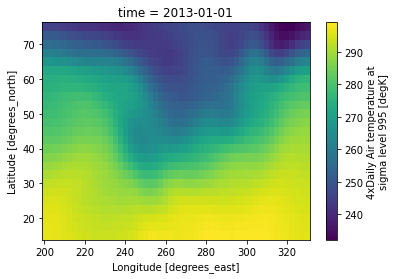

In [51]:
da_roll.plot()

## Block windows of fixed length: `Coarsen`
- unlike rolling: **windows never overlap**

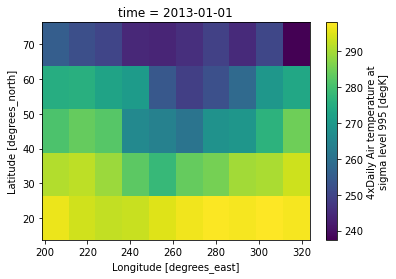

In [55]:
(
    data
    .coarsen(lat=5, lon=5, boundary='trim')
    .mean()
    .plot()
)

**in cell below, trim specifies discarding coords leftover by the coarsen specifications**

In [60]:
(data
    .coarsen(lat=5, lon=5, boundary='trim').std()
)

<xarray.DataArray 'air' (lat: 5, lon: 10)>
12.73 12.19 11.7 6.48 2.827 2.738 2.491 ... 4.97 1.925 1.98 1.824 1.17 0.9438
Coordinates:
  * lat      (lat) float32 70.0 57.5 45.0 32.5 20.0
  * lon      (lon) float32 205.0 217.5 230.0 242.5 ... 280.0 292.5 305.0 317.5
    time     datetime64[ns] 2013-01-01
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

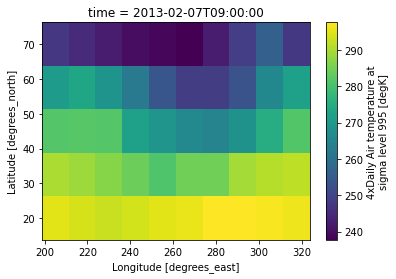

In [58]:
(
    da
    .coarsen(time=100, lat=5, lon=5, boundary='trim')
    .mean()
).isel(time=1).plot()

## Coarsen supports `reduce` for custom reductions

**Exercise:** use `coarsen.reduce` to apply `np.mean` in 5x5 (latxlon) point blocks of `data`

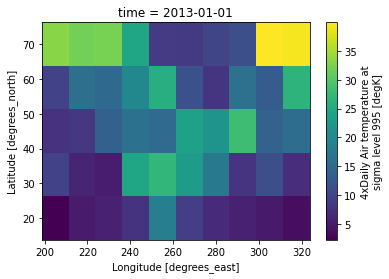

In [63]:
data.coarsen(lat=5, lon=5, boundary='trim').reduce(np.p).plot()

### Coarsen supports `construct` for block reshaping

- this is usually a good alternative to `np.reshape`

A simple example splits a 2 year long monthy 1D time series into a 2D array shaped (year x month)

In [80]:
months = xr.DataArray(np.tile(np.arange(1,13), reps=2), dims='time', coords={'time': np.arange(1,25)
})
months

<xarray.DataArray (time: 24)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24

In [82]:
#break time into 2 new dimensions : year, month

months.coarsen(time=12).construct(time=('year','month'))

<xarray.DataArray (year: 2, month: 12)>
1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 12
Coordinates:
    time     (year, month) int64 1 2 3 4 5 6 7 8 9 ... 17 18 19 20 21 22 23 24
Dimensions without coordinates: year, month

**Note:**
1. `time` dimension was also reshaped
2. the new dimensions `month` and `year` don't have any coordinate labels associated with them

**Exercise:** Reshape the `time` dimension of the DataArray `monthly` to year x month and visulaize the seasonal cycle for 2 years at 250˚E

In [83]:
monthly

<xarray.DataArray 'air' (time: 24, lat: 25, lon: 53)>
244.5 244.7 244.7 244.5 244.2 243.8 ... 298.2 298.1 298.1 297.7 297.7 297.7
Coordinates:
  * time     (time) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [89]:
#split time dim into year x month
year_month = monthly.coarsen(time=12).construct(time=('year','month'))
year_month

<xarray.DataArray 'air' (year: 2, month: 12, lat: 25, lon: 53)>
244.5 244.7 244.7 244.5 244.2 243.8 ... 298.2 298.1 298.1 297.7 297.7 297.7
Coordinates:
    time     (year, month) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
Dimensions without coordinates: year, month
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [94]:
#assign a coord value for year
year_month['year'] = np.unique(monthly.time.dt.year)

In [96]:
year_month['month'] = ['jan','feb','mar','apr','may','jun',
                       'jul','aug','sep','oct','nov','dec']

In [97]:
year_month

<xarray.DataArray 'air' (year: 2, month: 12, lat: 25, lon: 53)>
244.5 244.7 244.7 244.5 244.2 243.8 ... 298.2 298.1 298.1 297.7 297.7 297.7
Coordinates:
    time     (year, month) datetime64[ns] 2013-01-31 2013-02-28 ... 2014-12-31
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * year     (year) int64 2013 2014
  * month    (month) <U3 'jan' 'feb' 'mar' 'apr' ... 'sep' 'oct' 'nov' 'dec'
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

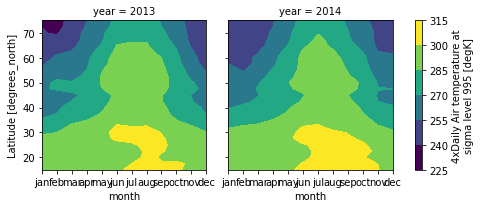

In [98]:
#seasonal cycle for 2 years
year_month.sel(lon=250).plot.contourf(col='year',x='month', y = 'lat')

# Label space

## Label space 'windows' or bins: GroupBy
generalization of `coarsen`: sometimes the windows you want are not regular
- `groupby`: eg. climatologies, composites, works when 'groups' are exact eg. characters or integers not floats
- `groupby_bins`: binning operations eg histograms
- `resample`: groupby but specialized for time grouping

### Deconstructing GroupBy

- commonly called 'split-apply-combine'

1. 'split': break dataset into groups
2. 'apply': apply an operation, usually a reduction like `mean`
3. 'combine': concatenate results from apply step along new 'group' dimension

There is a **first** step: 'identifying groups', also called factorization' (or 'binning'). Usually this is the hardest part

so: 'identify groups' -> 'split into groups' -> 'apply function' -> 'combine results'

In [100]:
da.groupby('time.month')

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

In [101]:
da.groupby('time.month').mean()

<xarray.DataArray 'air' (month: 12, lat: 25, lon: 53)>
246.3 246.4 246.2 245.8 245.2 244.6 ... 298.1 298.0 298.0 297.6 297.6 297.5
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [102]:
da.time.dt.month

<xarray.DataArray 'month' (time: 2920)>
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

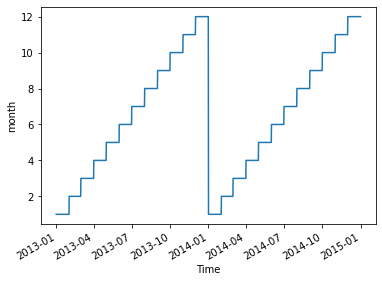

In [105]:
da.time.dt.month.plot()

In [106]:
data.groupby_bins('lat', bins = [20,35,40,45,50])

DataArrayGroupBy, grouped over 'lat_bins'
4 groups with labels (45.0,, 50.0], ..., (20.0,, 35.0].

In [107]:
da.resample(time='M')

DataArrayResample, grouped over '__resample_dim__'
24 groups with labels 2013-01-31, ..., 2014-12-31.

### Constructing group labels

xarray uses `pandas.factorize` for `groupby` and `pandas.cut` for `groupby_bins` 

if the automatic group detection doesn't work for your problem then these functions are useful for constructing 'group labels' in many cases:

1. numpy.digitize (binning)
2. numpy.searchsorted supports many other data types
3. pandas.factorize supports characters, strings..
4. pandas.cut for binning
5. DataArray.isin

**more commonly useful are 'datetime components'**

In [108]:
da.time

<xarray.DataArray 'time' (time: 2920)>
2013-01-01 2013-01-01T06:00:00 ... 2014-12-31T12:00:00 2014-12-31T18:00:00
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

In [109]:
da.time.dt.day

<xarray.DataArray 'day' (time: 2920)>
1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 ... 28 28 28 29 29 29 29 30 30 30 30 31 31 31 31
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

In [111]:
da['time.day']

<xarray.DataArray 'day' (time: 2920)>
1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 ... 28 28 28 29 29 29 29 30 30 30 30 31 31 31 31
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

In [112]:
da.time.dt.season

<xarray.DataArray 'season' (time: 2920)>
'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF'
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00

### Use `isin` to construct custom seasons

In [116]:
month = da.time.dt.month.data
month

array([ 1,  1,  1, ..., 12, 12, 12])

In [115]:
season = np.full(month.shape, "    ")
season

array(['    ', '    ', '    ', ..., '    ', '    ', '    '], dtype='<U4')

In [120]:
season[np.isin(month, [12,1,2])] = 'DJF'
season[np.isin(month, [3,4,5])] = 'MAM'
season[np.isin(month, [6,7,8,9])] = 'JJAS'
season[np.isin(month, [10,11])] = 'ON'
season = da.time.copy(data=season)
season

<xarray.DataArray 'time' (time: 2920)>
'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' ... 'DJF' 'DJF' 'DJF' 'DJF' 'DJF' 'DJF'
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  time
    long_name:      Time

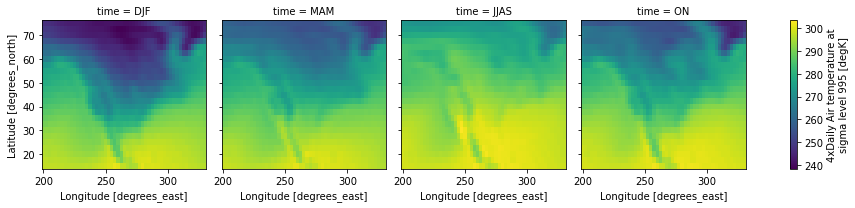

In [124]:
da.groupby(season).mean().reindex(time=['DJF','MAM','JJAS','ON']).plot(col='time')

### In most cases, avoida for loop using `map`

In [126]:
def iqr(da,dim):
    '''calculates interquartile range'''
    return (da.quantile(q=0.75, dim=dim) - da.quantile(q=0.25, dim=dim)).rename('iqr')

In [127]:
da.groupby('time.month').map(iqr, dim='time')

<xarray.DataArray 'iqr' (month: 12, lat: 25, lon: 53)>
7.528 7.425 7.025 6.65 6.152 6.135 6.127 ... 0.9 0.9 0.855 1.0 1.3 1.432 1.5
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]